<a href="https://colab.research.google.com/github/paavlito/TFG_PabloGarciaBolivar/blob/main/TFG_PabloGarciaBolivar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install -q datasets
!sudo apt install -q tesseract-ocr
!pip install -q pytesseract
!pip install math
!pip install numpy

exit(0)

In [ ]:
%%capture
!pip install -q transformers
!pip install -q -U sentence-transformers
!pip install -q pyyaml==5.1
!pip install -q torch==1.08.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

# after the above installation we need to restart runtime
exit(0)

  0%|          | 0/2 [00:00<?, ?it/s]

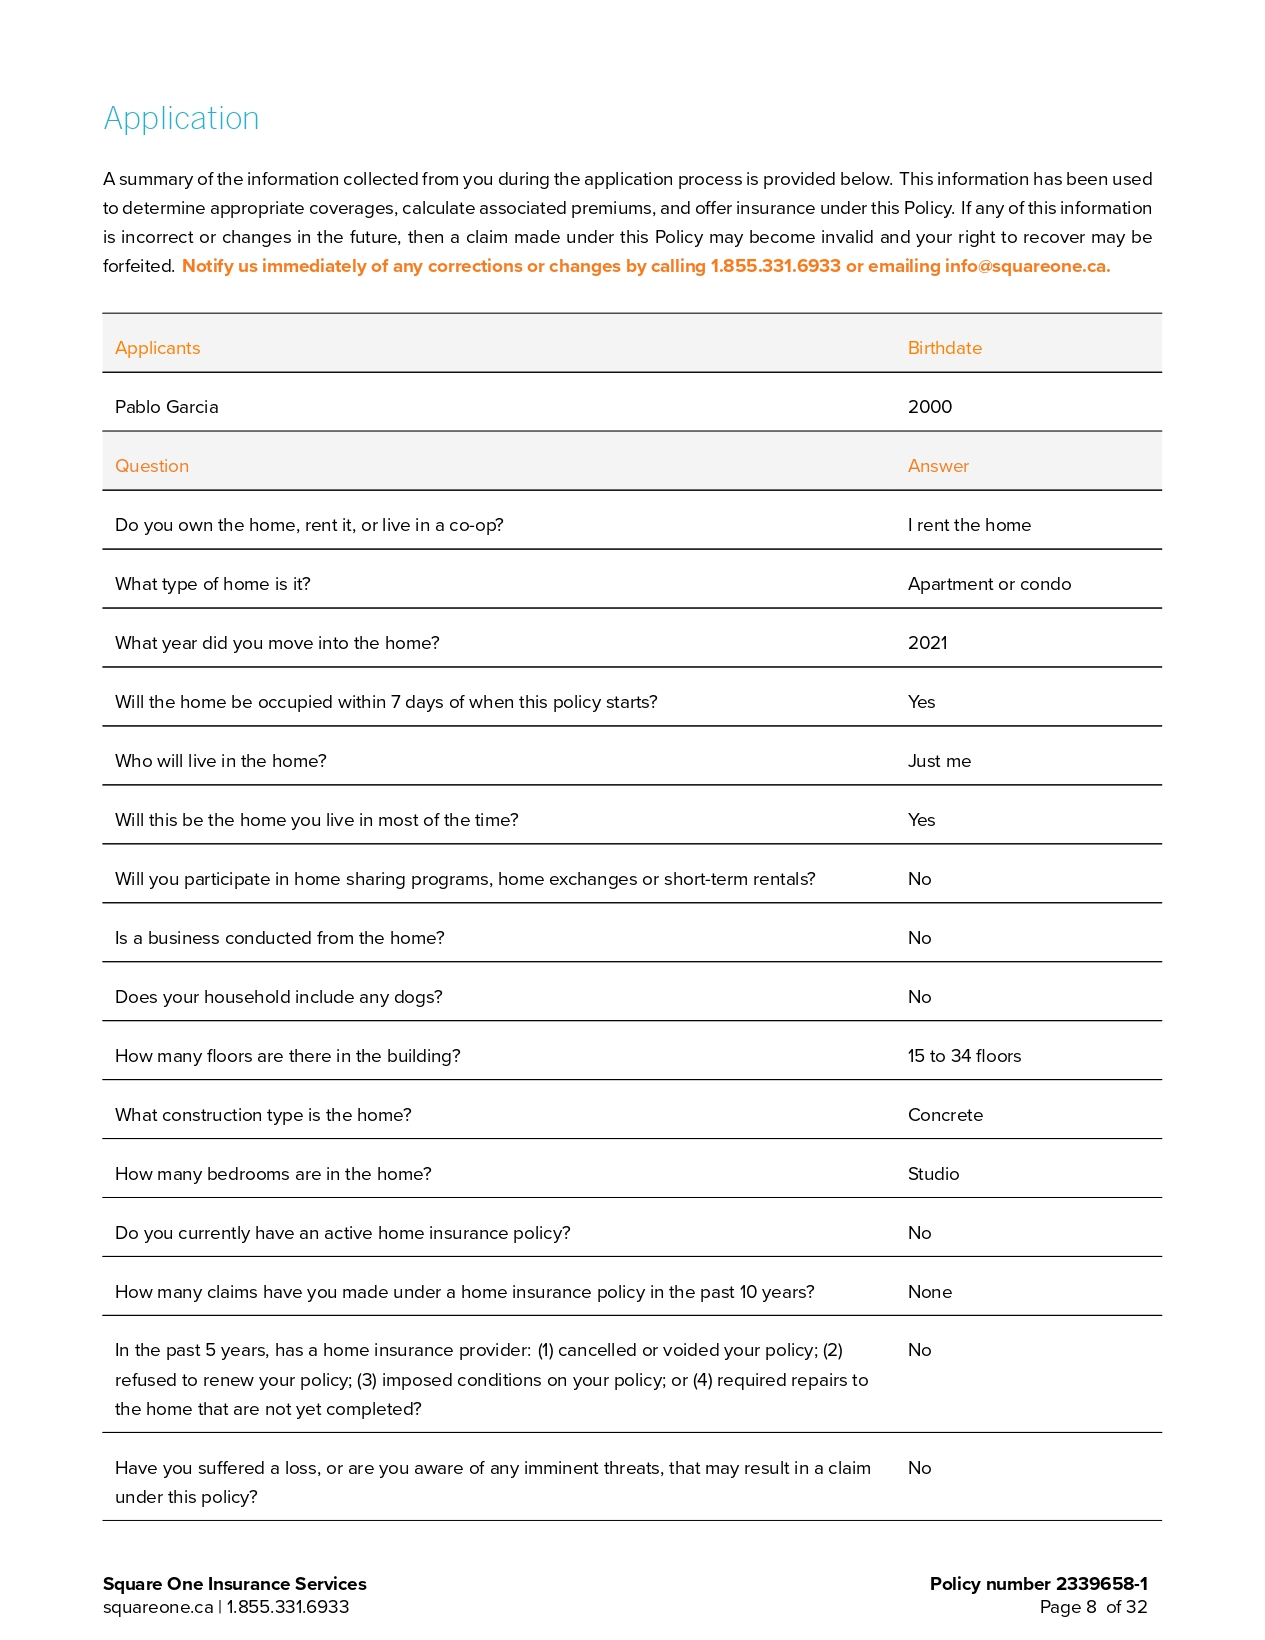

In [ ]:
## DESCARGAMOS EL DATASET DE FUNSD
from datasets import load_dataset 

datasets = load_dataset("nielsr/funsd")

labels = datasets['train'].features['ner_tags'].feature.names

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

## IMPORTAMOS LA IMAGEN A LA QUE SE LE QUIERE HACER INFERENCIA
imagepath = 'image.jpg'

from PIL import Image, ImageDraw, ImageFont

image = Image.open(imagepath)
image = image.convert("RGB")
area = 10, 10, image.size[0], image.size[1]*1
image = image.crop(area)
image

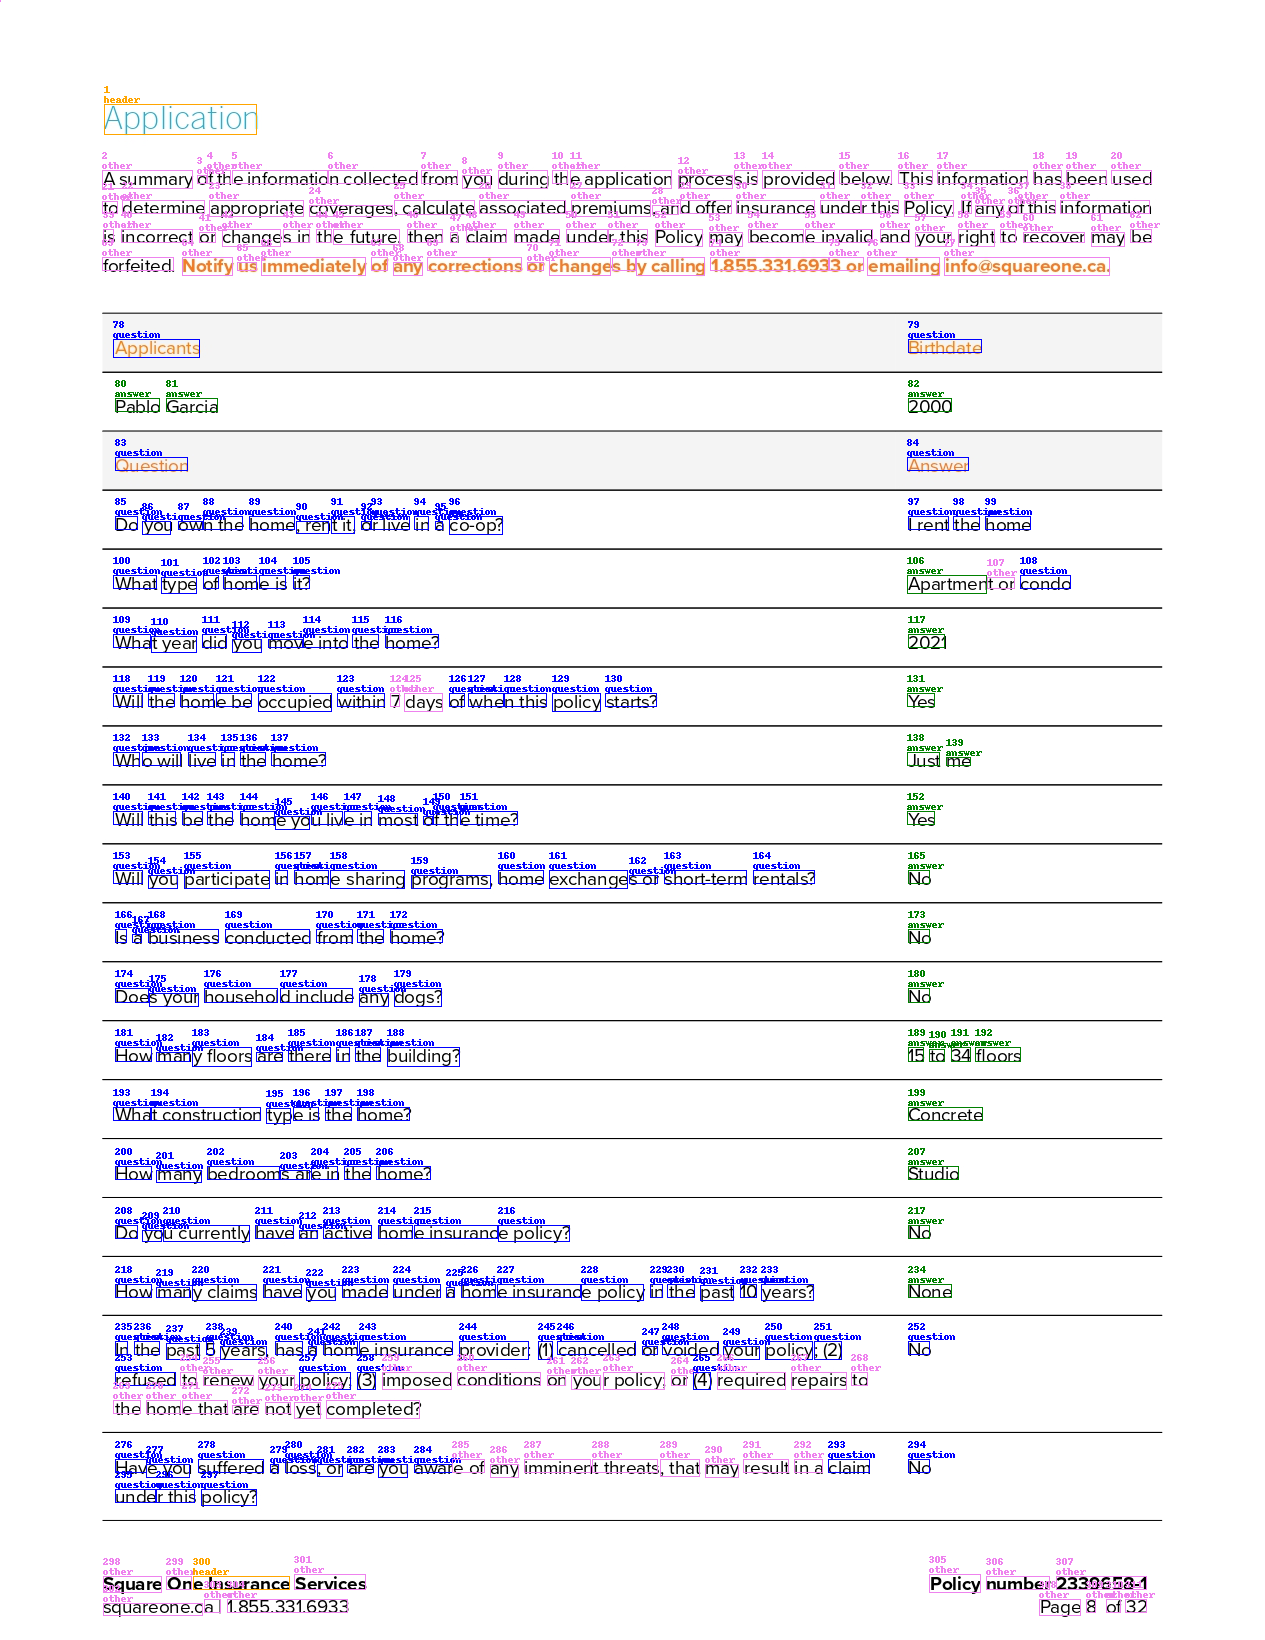

In [ ]:
## DESCARGAMOS EL ENCODER
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')


## USAMOS LA GPU SI ESTÁ DISPONIBLE
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k,v in encoding.items():
  encoding[k] = v.to(device)


## DESCARGAMOS EL MODELO
from transformers import LayoutLMv2ForTokenClassification

# load the fine-tuned model from the hub
model = LayoutLMv2ForTokenClassification.from_pretrained("nielsr/layoutlmv2-finetuned-funsd")
model.to(device)

# forward pass
outputs = model(**encoding)


def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size

import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

image = Image.open(imagepath)
image = image.convert("RGB")
image = image.crop(area)

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box, i in zip(true_predictions, true_boxes, range(len(true_predictions))):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0], box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    draw.text((box[0], box[1]-20), text=str(i), fill=label2color[predicted_label], font=font)
    
image

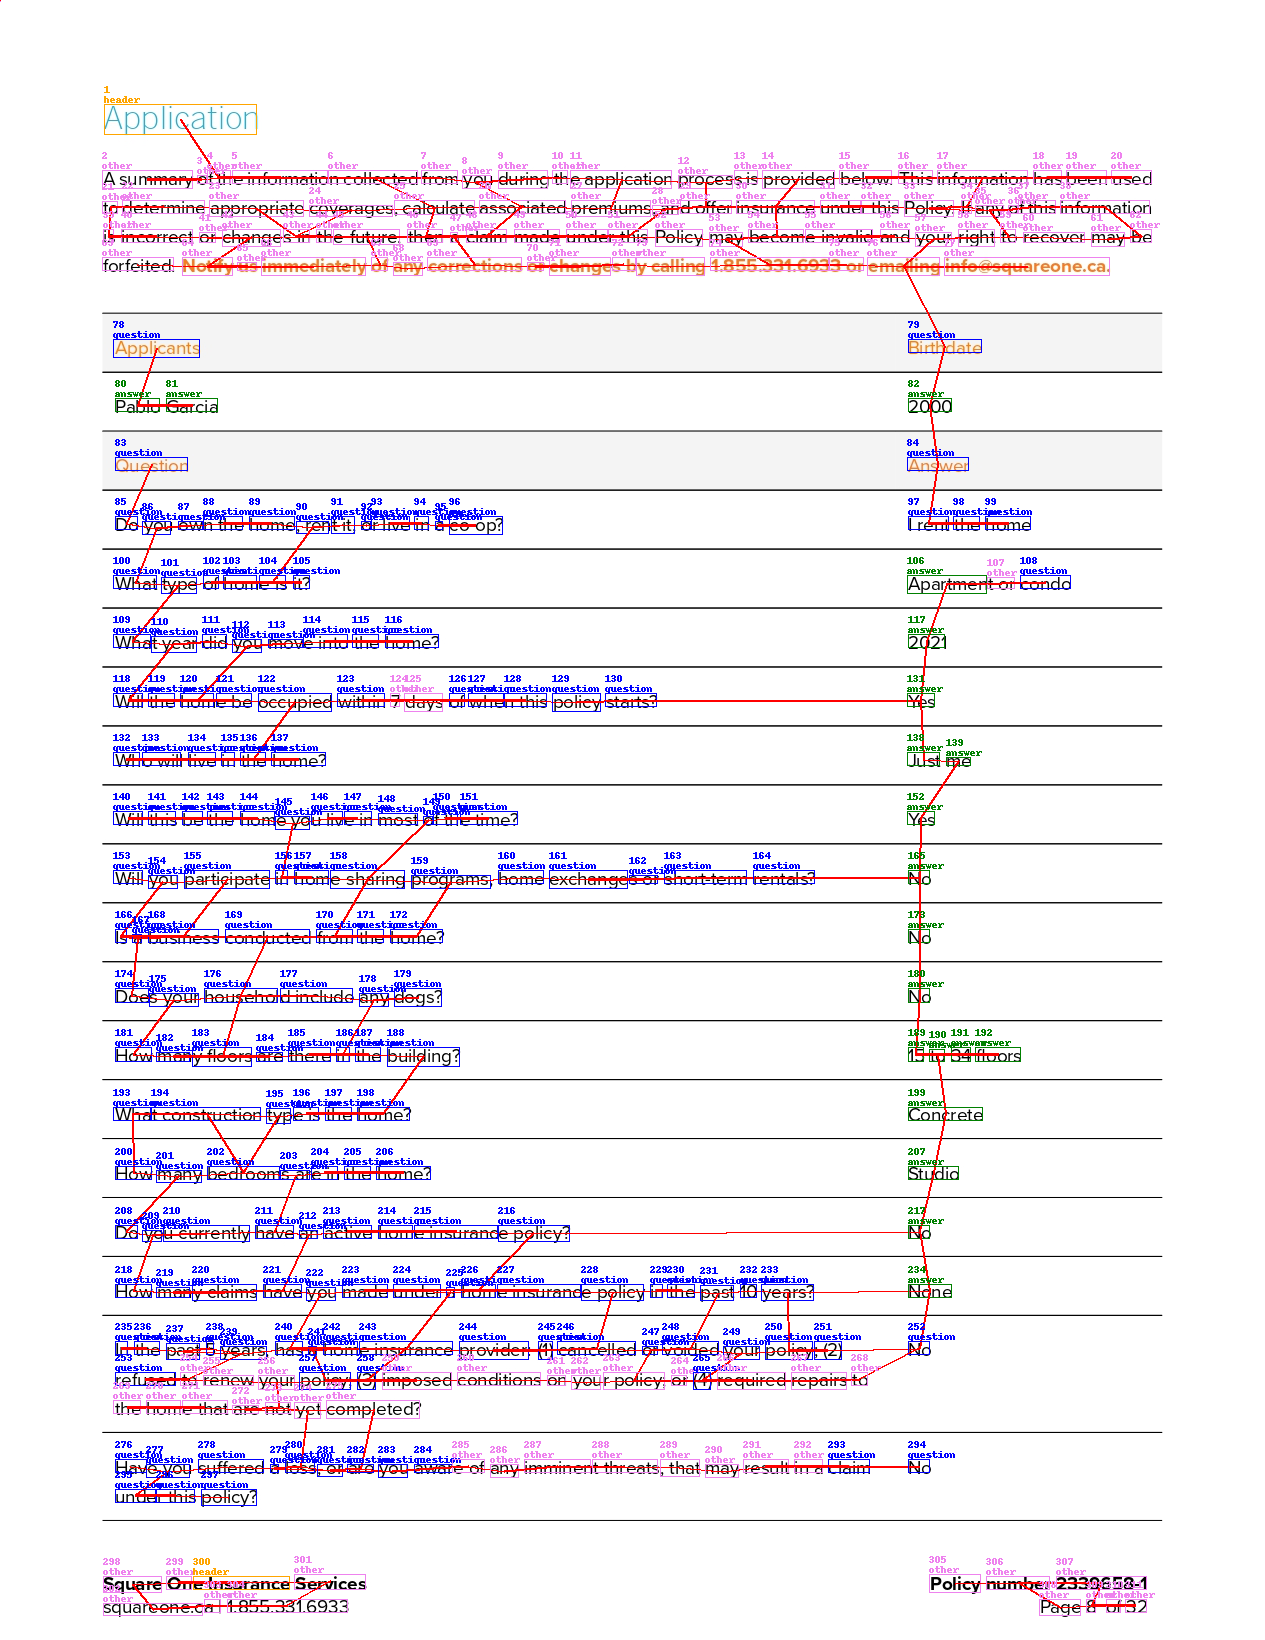

In [ ]:
## CALCULAMOS EL CENTRO DE CADA BOUNDING BOX
x_center = []
y_center = []

for i in range(len(true_boxes)):
  x_center.append((true_boxes[i][0]+true_boxes[i][2])/2)
  y_center.append((true_boxes[i][1]+true_boxes[i][3])/2)


## BUSCAMOS LOS BOXES MÁS CERCANOS HACIA LA DERECHA Y HACIA ABAJO CON LAS FUNCIONES NEXT RIGHT Y NEXT BELOW
x_center = np.array(x_center)
y_center = np.array(y_center)

# Función NEXT Right (Base)
def nextRight(x_center, y_center, width_range_factor, height_range_factor):

  x_right = []

  for i in range(len(x_center)):

    aux_x = x_center[i]

    x_center[i] = 99999

    valid_x = []

    for j in range(len(y_center)):

      if (abs(aux_x - x_center[j]) >= (width/width_range_factor) or abs(y_center[i] - y_center[j]) >= (height/height_range_factor)):
        valid_x.append(99999)
      else:
        valid_x.append(x_center[j])


    check_sign_x = valid_x - aux_x # si la resta es positiva valid_x está a la derecha de aux_x

    for k in range(len(check_sign_x)):
      if(check_sign_x[k] < 0):
        check_sign_x[k] = 99999;

    idx = (check_sign_x).argmin()

    if (idx == 0):
      x_right.append(i)
    else:
      x_right.append(idx)

    x_center[i] = aux_x

  return x_right

# Función NEXT Below (Base)
def nextBelow(x_center, y_center, width_range_factor, height_range_factor):
  
  y_below = []

  for i in range(len(y_center)):

    aux_y = y_center[i]

    y_center[i] = 99999

    valid_y = []

    for j in range(len(x_center)):

      if (abs(x_center[i] - x_center[j]) >= (width/width_range_factor) or abs(aux_y - y_center[j]) >= (height/height_range_factor)):
        valid_y.append(99999)
      else:
        valid_y.append(y_center[j])


    check_sign_y = valid_y - aux_y # si la resta es positiva valid_x está a debajo de aux_x

    for k in range(len(check_sign_y)):
      if(check_sign_y[k] < 0 or check_sign_y[k] > 9999999):
        check_sign_y[k] = 99999;

    idy = (check_sign_y).argmin()
    
    if (idy == 0):
      y_below.append(i)
    else:
      y_below.append(idy)

    y_center[i] = aux_y

  return y_below

# Usamos las funciones NEXT
x_right = nextRight(x_center, y_center, 3, 80)
y_below = nextBelow(x_center, y_center, 20, 20)


# Enseñamos por pantalla los resultados de estas funciones
image = Image.open(imagepath)
image = image.convert("RGB")
image = image.crop(area)

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box, i in zip(true_predictions, true_boxes, range(len(x_center))):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0], box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    draw.text((box[0], box[1]-20), text=str(i), fill=label2color[predicted_label], font=font)
    draw.line([(x_center[i],y_center[i]),(x_center[x_right[i]],y_center[x_right[i]])], fill='red', width=2, joint=None)
    draw.line([(x_center[i],y_center[i]),(x_center[y_below[i]],y_center[y_below[i]])], fill='red', width=2, joint=None)

image

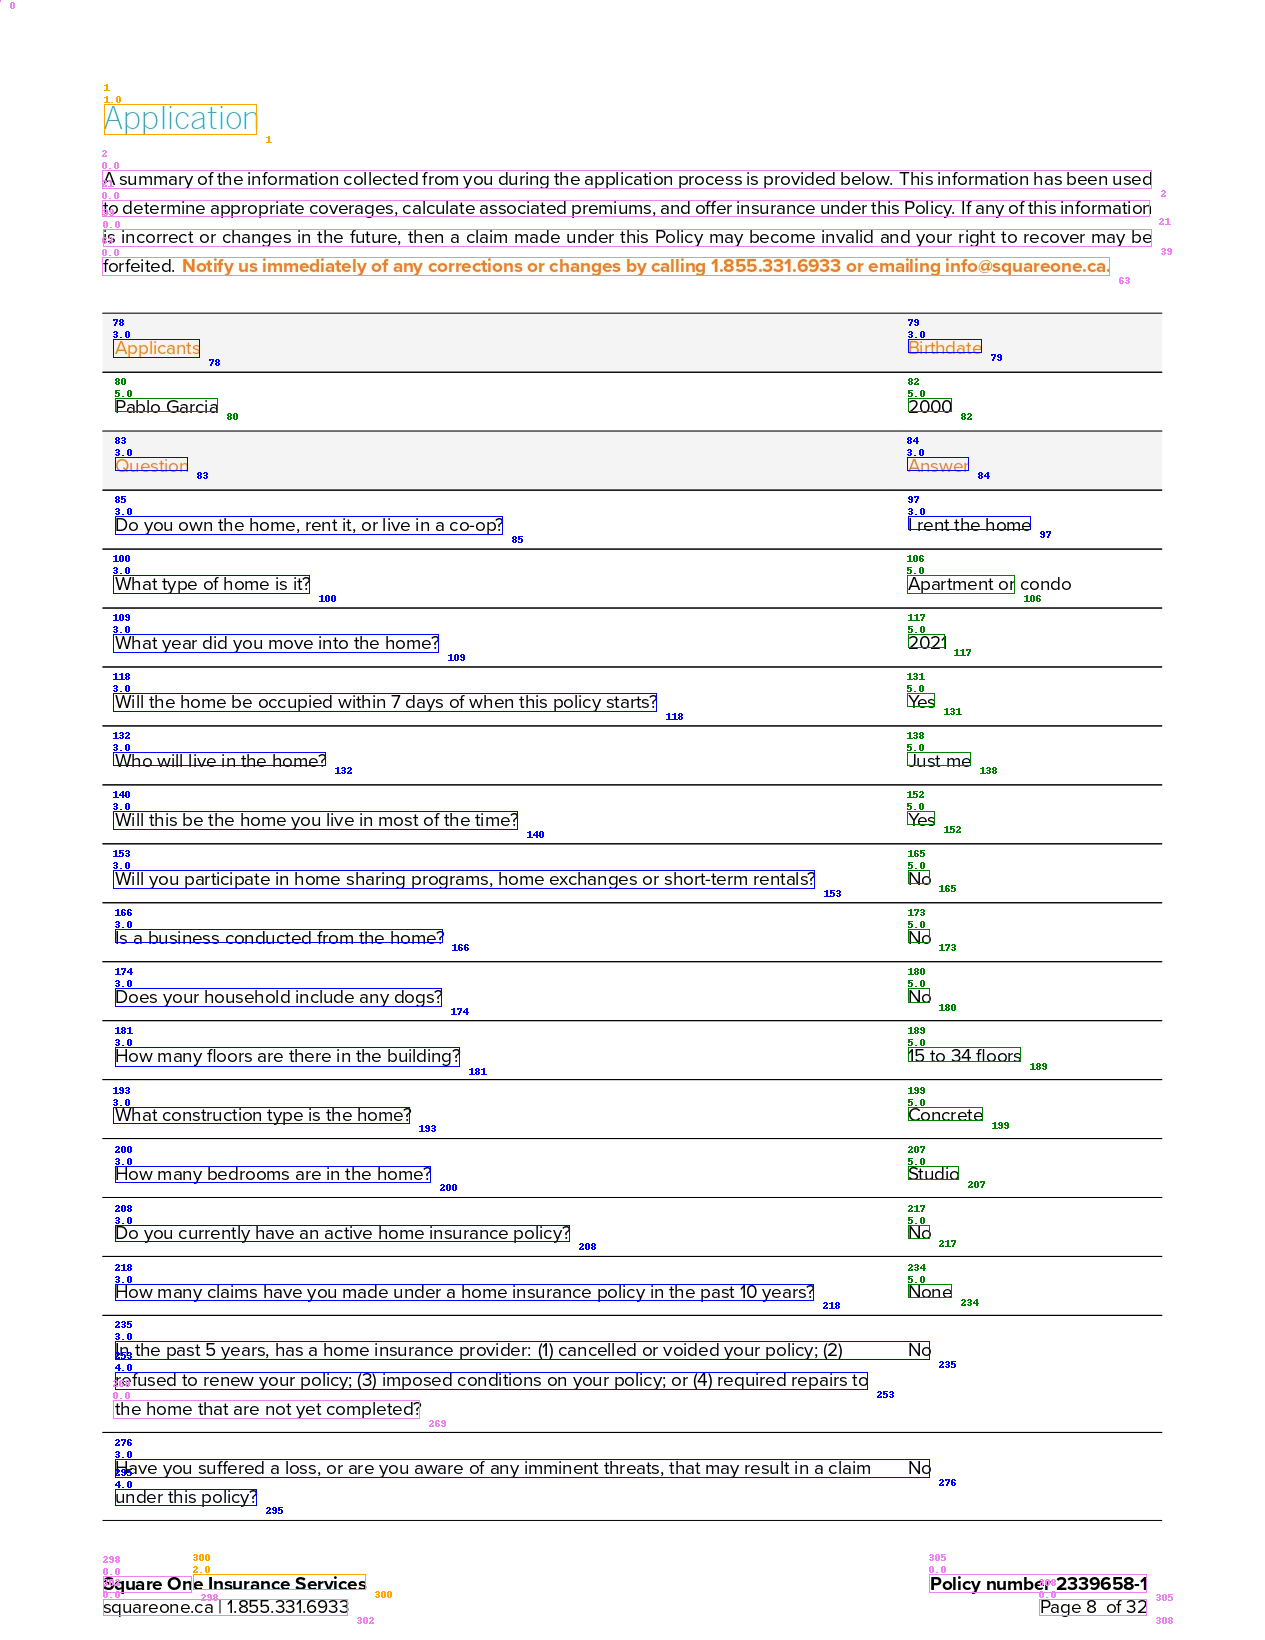

In [ ]:
## VAMOS A CREAR FRASES DE UNA LINEA

# Asignamos un número de etiqueta a cada etiqueta
id_predictions = np.zeros(len(true_predictions))

for i in range(len(true_predictions)):
  if (true_predictions[i] == 'O'):
    id_predictions[i] = 0
  elif (true_predictions[i] == 'B-HEADER'):
    id_predictions[i] = 1
  elif (true_predictions[i] == 'I-HEADER'):
    id_predictions[i] = 2
  elif (true_predictions[i] == 'B-QUESTION'):
    id_predictions[i] = 3
  elif (true_predictions[i] == 'I-QUESTION'):
    id_predictions[i] = 4
  elif (true_predictions[i] == 'B-ANSWER'):
    id_predictions[i] = 5
  elif (true_predictions[i] == 'I-ANSWER'):
    id_predictions[i] = 6
  else:
    id_predictions[i] = -1

# Algoritmo de unión de token para formar Frases de Una Línea
sentence_matrix = np.zeros((len(x_right), len(y_below)))
sentence_type = np.zeros(len(x_right)) - 1  # -1: Not Beginning of Sentence, 0: Other, 1: Header-B, 3: Question-B, 5: Answer-B                                                                                   # 2: Header-I, 4: Question-I, 6: Answer-I

aux_x_right = list(x_right)

for i in range(len(x_right)):
  mark = i

  # 0: 'O'
  if(id_predictions[i] == 0 and aux_x_right[i] != -1): # si su id == 0 y no se ha utilizado ya este token entramos
    sentence_matrix[i][i] = 1
    sentence_type[i] = 0
    while(id_predictions[x_right[mark]] == 0 and x_right[mark] != mark and mark + 1 < len(id_predictions)-1 and (abs(true_boxes[x_right[mark]][0] - true_boxes[mark][2]) < (width/20))):
      mark += 1
      sentence_matrix[i][mark] = 1
      aux_x_right[mark] = -1

  # 1: 'B-HEADER'
  elif(id_predictions[i] == 1 and aux_x_right[i] != -1):
    sentence_matrix[i][i] = 1
    sentence_type[i] = 1
    while((id_predictions[x_right[mark]] == 2 or id_predictions[x_right[mark]] == 1 or id_predictions[x_right[mark]] == 0 ) and (x_right[mark] != mark and mark + 1 < len(id_predictions)-1) and (abs(true_boxes[x_right[mark]][0] - true_boxes[mark][2]) < (width/20))):
      mark += 1
      sentence_matrix[i][mark] = 1
      aux_x_right[mark] = -1

  # 2: 'I-HEADER'
  elif(id_predictions[i] == 2 and aux_x_right[i] != -1):
    sentence_matrix[i][i] = 1
    sentence_type[i] = 2
    while((id_predictions[x_right[mark]] == 2 or id_predictions[x_right[mark]] == 0) and x_right[mark] != mark and mark + 1 < len(id_predictions)-1 and (abs(true_boxes[x_right[mark]][0] - true_boxes[mark][2]) < (width/20))):
      mark += 1
      sentence_matrix[i][mark] = 1
      aux_x_right[mark] = -1

  # 3: 'B-QUESTION'
  elif(id_predictions[i] == 3 and aux_x_right[i] != -1):
    sentence_matrix[i][i] = 1
    sentence_type[i] = 3
    while((id_predictions[x_right[mark]] == 4 or id_predictions[x_right[mark]] == 0) and (x_right[mark] != mark and mark + 1 < len(id_predictions)-1) and (abs(true_boxes[x_right[mark]][0] - true_boxes[mark][2]) < (width/10))):
      mark += 1
      sentence_matrix[i][mark] = 1
      aux_x_right[mark] = -1

  # 4: 'I-QUESTION'
  elif(id_predictions[i] == 4 and x_right[mark] != mark and aux_x_right[i] != -1):
    sentence_matrix[i][i] = 1
    sentence_type[i] = 4
    while((id_predictions[x_right[mark]] == 4 or id_predictions[x_right[mark]] == 0) and x_right[mark] != mark and mark + 1 < len(id_predictions)-1 and (abs(true_boxes[x_right[mark]][0] - true_boxes[mark][2]) < (width/10))):
      mark += 1
      sentence_matrix[i][mark] = 1
      aux_x_right[mark] = -1

  # 5: 'B-ANSWER'
  elif(id_predictions[i] == 5 and aux_x_right[i] != -1):
    sentence_matrix[i][i] = 1
    sentence_type[i] = 5
    while((id_predictions[x_right[mark]] == 6 or id_predictions[x_right[mark]] == 0) and (x_right[mark] != mark and mark + 1 < len(id_predictions)-1) and (abs(true_boxes[x_right[mark]][0] - true_boxes[mark][2]) < (width/20))):
     mark += 1
     sentence_matrix[i][mark] = 1
     aux_x_right[mark] = -1

  # 6: 'I-ANSWER'
  elif(id_predictions[i] == 6 and x_right[mark] != mark and aux_x_right[i] != -1):
    sentence_matrix[i][i] = 1
    sentence_type[i] = 6
    while((id_predictions[x_right[mark]] == 6 or id_predictions[x_right[mark]] == 0) and x_right[mark] != mark and mark + 1 < len(id_predictions)-1 and (abs(true_boxes[x_right[mark]][0] - true_boxes[mark][2]) < (width/20))):
      mark += 1
      sentence_matrix[i][mark] = 1
      aux_x_right[mark] = -1

# Creamos los nuevos bounding boxes de las Frases de Una Línea
sen_x0 = (sentence_matrix*(np.array(true_boxes)[:,0]))
sen_x0 = np.where(sen_x0>0, sen_x0, np.inf).min(axis=1)
sen_x0 = np.where(sen_x0<999999, sen_x0, 0)

sen_y0 = (sentence_matrix*(np.array(true_boxes)[:,1]))
sen_y0 = np.where(sen_y0>0, sen_y0, np.inf).min(axis=1)
sen_y0 = np.where(sen_y0<999999, sen_y0, 0)

sen_x1 = (sentence_matrix*(np.array(true_boxes)[:,2])).max(axis=1)
sen_y1 = (sentence_matrix*(np.array(true_boxes)[:,3])).max(axis=1)

sen_x0 = sen_x0[sen_x0 != 0]
sen_x1 = sen_x1[sen_x1 != 0]
sen_y0 = sen_y0[sen_y0 != 0]
sen_y1 = sen_y1[sen_y1 != 0]

zero = np.array([0])

sen_x0 = np.concatenate((zero,sen_x0), axis=0)
sen_x1 = np.concatenate((zero,sen_x1), axis=0)
sen_y0 = np.concatenate((zero,sen_y0), axis=0)
sen_y1 = np.concatenate((zero,sen_y1), axis=0)

sen_box = np.concatenate( [np.array([sen_x0]).T, np.array([sen_y0]).T, np.array([sen_x1]).T, np.array([sen_y1]).T], axis = 1)

label2color = {0 : 'violet',
               1 : 'orange',
               2 : 'orange',
               3 : 'blue',
               4 : 'blue',
               5 : 'green',
               6 : 'green'
}

# Enseñamos los resultados por pantalla
image = Image.open(imagepath)
image = image.convert("RGB")
image = image.crop(area)

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

k = 0
for i in range(len(sentence_type)):
  if(sentence_type[i] != -1):
    draw.text((sen_box[k][0], sen_box[k][1]-10), text=str(sentence_type[i]), fill=label2color[sentence_type[i]], font=font)
    draw.text((sen_box[k][0], sen_box[k][1]-22), text=str(i), fill=label2color[sentence_type[i]], font=font)
    draw.text((sen_box[k][2]+10, sen_box[k][3]), text=str(i), fill=label2color[sentence_type[i]], font=font)
    
    sen_box_temp = [sen_box[k][0], sen_box[k][1], sen_box[k][2], sen_box[k][3]]
    draw.rectangle(sen_box_temp, outline=label2color[sentence_type[i]])

    k += 1

image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


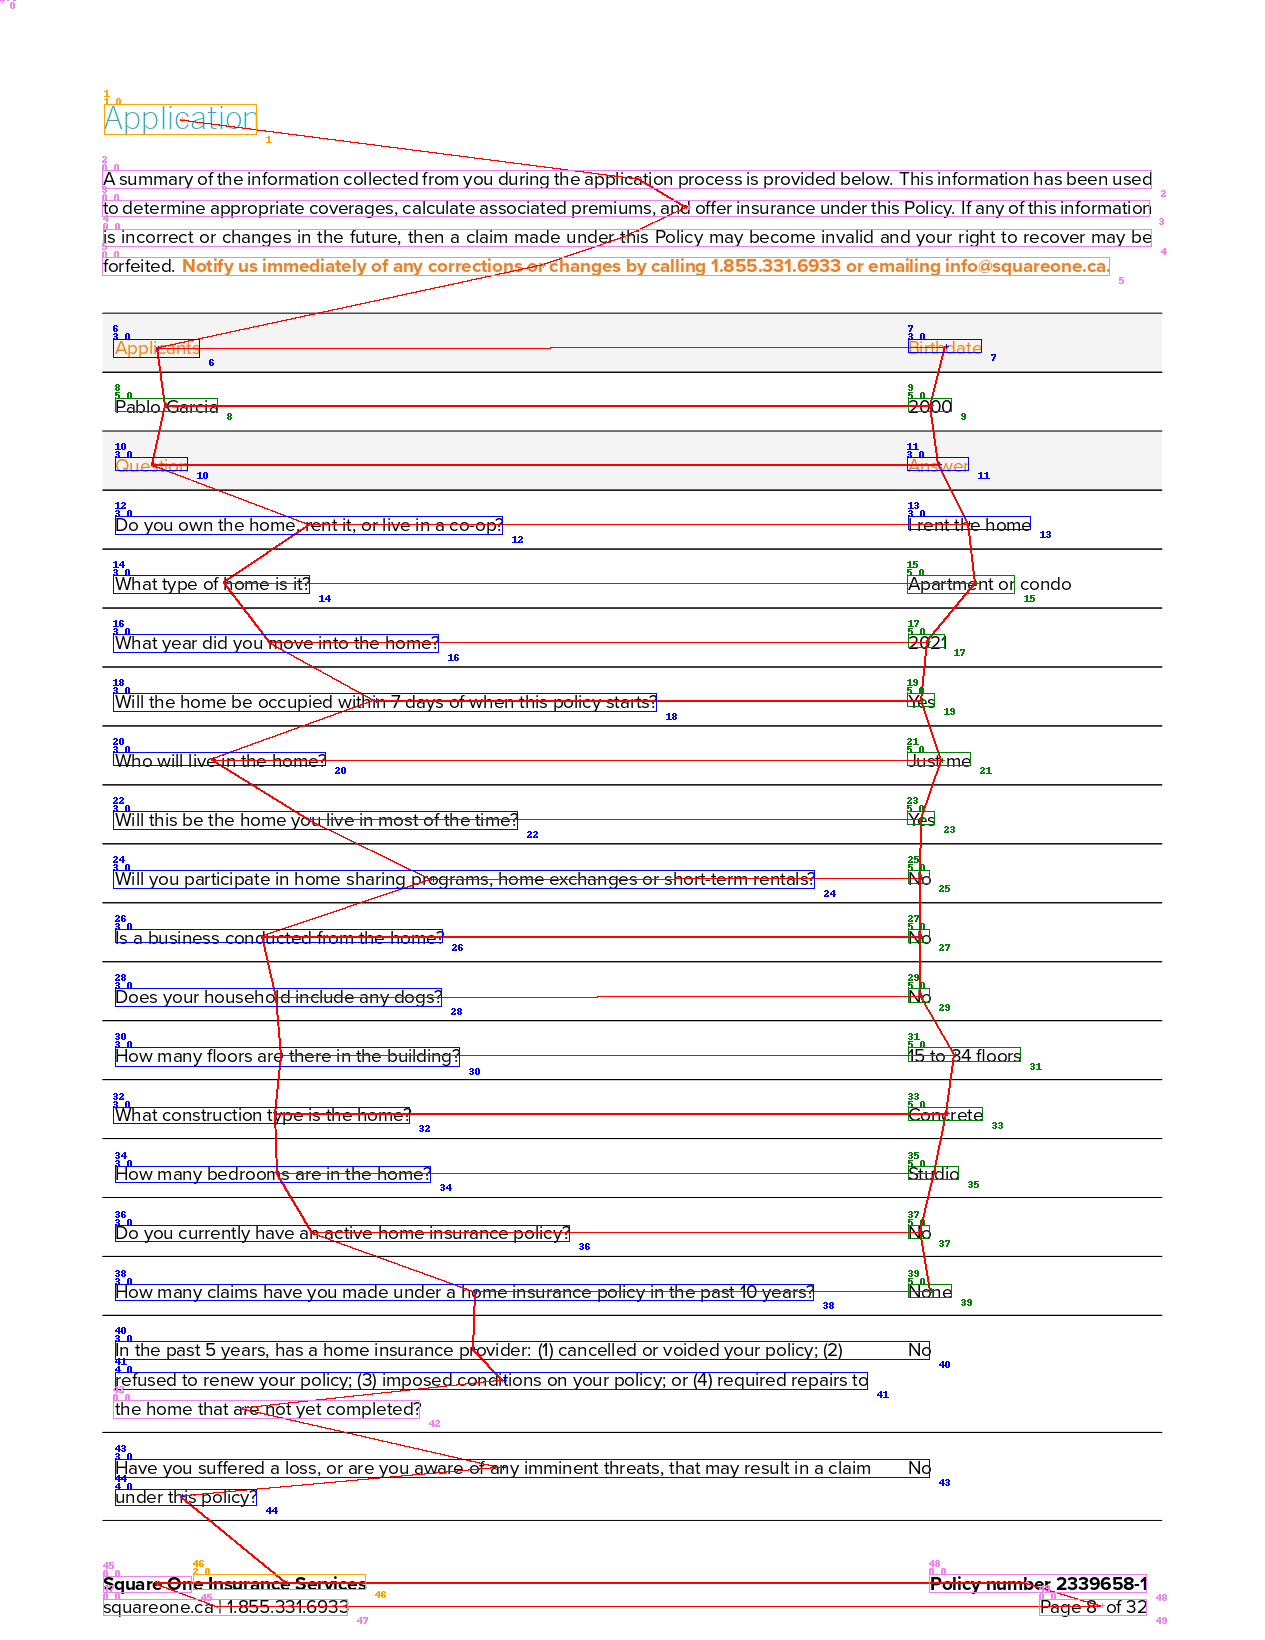

In [ ]:
### UNIMOS LAS FRASES DE UNA LÍNEA PARA FORMAR FRASES COMPLETAS O PÁRRAFOS

## Calculamos los nuevos centros de las Frases de Una Línea

# Al sumar las filas de las sentence_matrix podemos saber de cuantas palabras esta compuesta cada fila
suma_de_filas = np.sum(sentence_matrix, axis=1)
suma_de_filas

# Calculamos un 'centro' calculando la media de centros de todas las palabras que componen las snetence
# se podría calcular el centro dividiendo el ancho total entre 2, pero este otro método también vale
sen_x_center = np.sum(sentence_matrix*x_center, axis=1) / suma_de_filas
sen_y_center = np.sum(sentence_matrix*y_center, axis=1) / suma_de_filas

# De las transfromaciones anteriores aparecen N/A. Los quitamos
sen_x_center = sen_x_center[~np.isnan(sen_x_center)]
sen_y_center = sen_y_center[~np.isnan(sen_y_center)]


## Función NEXT Right (difCompare), modificaciones respecto a 'Base' explicadas en el paper
def nextRight_difCompare(x_center, y_center, xi_compare, xj_compare, width_range_factor, height_range_factor):

  x_right = []

  for i in range(len(x_center)):

    aux_x = x_center[i]

    x_center[i] = 99999

    valid_x = []

    for j in range(len(y_center)):

      if (abs(xi_compare[i] - xj_compare[j]) >= (width/width_range_factor) or abs(y_center[i] - y_center[j]) >= (height/height_range_factor)):
        valid_x.append(99999)
      else:
        valid_x.append(x_center[j])

    check_sign_x = valid_x - aux_x # si la resta es positiva valid_x está a la derecha de aux_x

    for k in range(len(check_sign_x)):
      if(check_sign_x[k] < 0):
        check_sign_x[k] = 99999;

    idx = (check_sign_x).argmin()

    if (idx == 0):
      x_right.append(i)
    else:
      x_right.append(idx)

    x_center[i] = aux_x

  return x_right


## Función NEXT Below (difCompare), modificaciones respecto a 'Base' explicadas en el paper
def nextBelow_difCompare(x_center, y_center, xi_compare, xj_compare, width_range_factor, height_range_factor):
  
  y_below = []

  for i in range(len(y_center)):

    aux_y = y_center[i]

    y_center[i] = 99999

    valid_y = []

    for j in range(len(x_center)):

      if (abs(xi_compare[i] - xj_compare[j]) >= (width/width_range_factor) or abs(aux_y - y_center[j]) >= (height/height_range_factor)):
        valid_y.append(99999)
      else:
        valid_y.append(y_center[j])
    
    # print(valid_y) # for debugging purposes

    check_sign_y = valid_y - aux_y # si la resta es positiva valid_x está a debajo de aux_x

    for k in range(len(check_sign_y)):
      if(check_sign_y[k] < 0 or check_sign_y[k] > 9999999):
        check_sign_y[k] = 99999;

    idy = (check_sign_y).argmin()
    
    if (idy == 0):
      y_below.append(i)
    else:
      y_below.append(idy)

    y_center[i] = aux_y

  return y_below

## Utilizamos las funciones Next Right (difCompare) y Next Below (difCompare)
sen_x_right = nextRight_difCompare(sen_x_center, sen_y_center, sen_box[:,2], sen_box[:,0], 1, 100) # 1, 80
sen_y_below = nextBelow_difCompare(sen_x_center, sen_y_center, sen_box[:,0], sen_box[:,0], 10, 15) # 10, 15

sentence_type_clean = []
sentence_type_clean = sentence_type[sentence_type != -1]


## Enseñamos por pantalla los resultados
image = Image.open(imagepath)
image = image.convert("RGB")
image = image.crop(area)

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

for i in range(len(sentence_type_clean)):
  draw.text((sen_box[i][0], sen_box[i][1]-8), text=str(sentence_type_clean[i]), fill=label2color[sentence_type_clean[i]], font=font)
  draw.text((sen_box[i][0], sen_box[i][1]-16), text=str(i), fill=label2color[sentence_type_clean[i]], font=font)
  draw.text((sen_box[i][2]+10, sen_box[i][3]), text=str(i), fill=label2color[sentence_type_clean[i]], font=font)
  draw.text((sen_x_center[i], sen_y_center[i]-5), text='+', fill=label2color[sentence_type_clean[i]], fonf=font)
      
  draw.line([(sen_x_center[i],sen_y_center[i]), (sen_x_center[sen_x_right[i]],sen_y_center[sen_x_right[i]])], fill= 'red', width=2, joint=None)
  draw.line([(sen_x_center[i],sen_y_center[i]), (sen_x_center[sen_y_below[i]],sen_y_center[sen_y_below[i]])], fill= 'red', width=2, joint=None)

  sen_box_temp = [sen_box[i][0], sen_box[i][1], sen_box[i][2], sen_box[i][3]]
  draw.rectangle(sen_box_temp, outline=label2color[sentence_type_clean[i]])

image


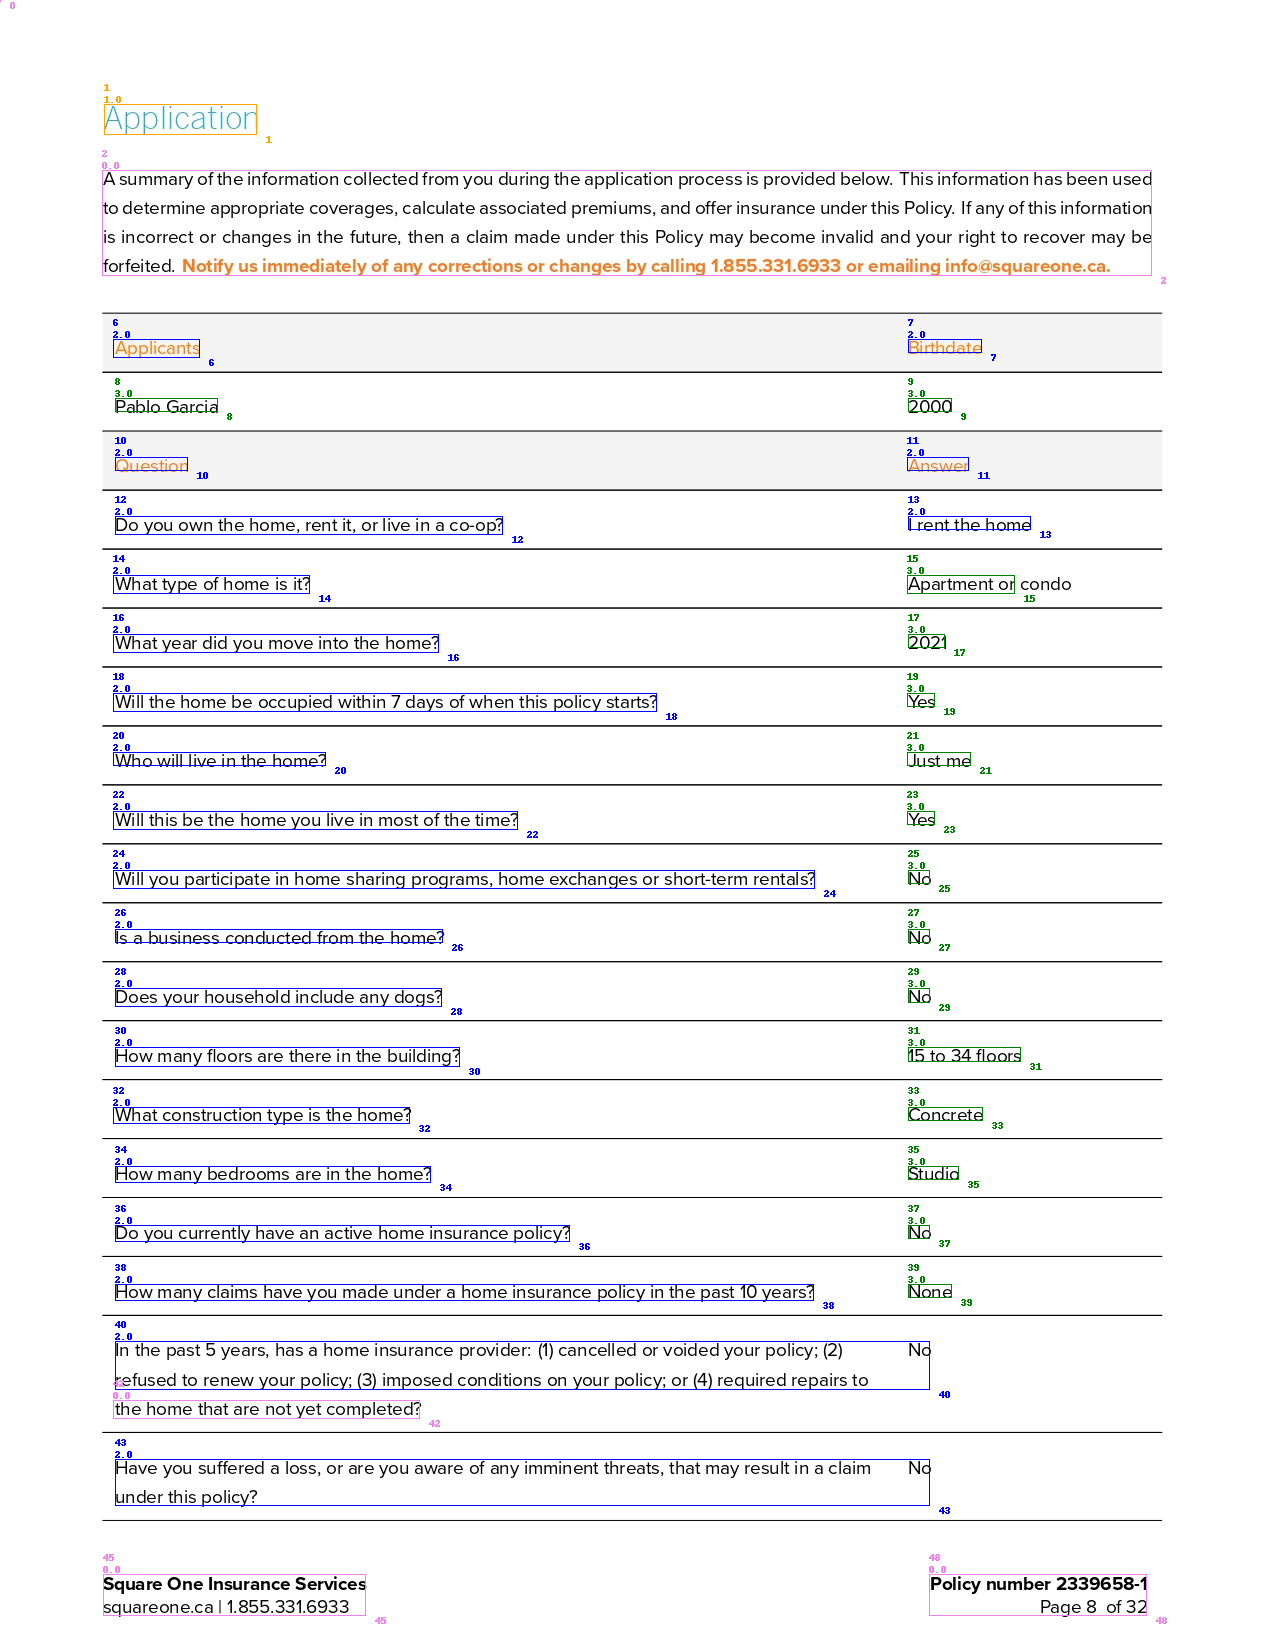

In [ ]:
## CREAMOS FRASES COMPLETAS Y PÁRRAFOS


par_matrix = np.zeros((len(sen_x_right), len(sen_y_below)))
par_type = np.zeros(len(sen_x_right)) - 1  # -1: No Link, 0: Other+Other, 1: Header-B + Header-I, 
                                        #  2: Question-B + Question-I, 3: Answer-B + Answer-I
aux_sen_y_below = list(sen_y_below)

for i in range(len(sen_y_below)):
  
  mark = i

  # Others con Others
  if(sentence_type_clean[i] == 0 and aux_sen_y_below[i] != -1):
    par_matrix[i][i] = 1
    par_type[i] = 0
    while(sentence_type_clean[sen_y_below[mark]] == 0 and sen_y_below[mark] != mark and mark + 1 < len(sentence_type_clean)-1):
      mark += 1
      par_matrix[i][mark] = 1
      aux_sen_y_below[mark] = -1
  
  elif(sentence_type_clean[i] == 1 and aux_sen_y_below[i] != -1):
    par_matrix[i][i] = 1
    par_type[i] = 1
    while(sentence_type_clean[sen_y_below[mark]] == 2 and sen_y_below[mark] != mark and mark + 1 < len(sentence_type_clean)-1):
      mark += 1
      par_matrix[i][mark] = 1
      aux_sen_y_below[mark] = -1

  elif(sentence_type_clean[i] == 3 and aux_sen_y_below[i] != -1):
    par_matrix[i][i] = 1
    par_type[i] = 2
    while(sentence_type_clean[sen_y_below[mark]] == 4 and sen_y_below[mark] != mark and mark + 1 < len(sentence_type_clean)-1):
      mark += 1
      par_matrix[i][mark] = 1
      aux_sen_y_below[mark] = -1

  elif(sentence_type_clean[i] == 5 and aux_sen_y_below[i] != -1):
    par_matrix[i][i] = 1
    par_type[i] = 3
    while(sentence_type_clean[sen_y_below[mark]] == 4 and sen_y_below[mark] != mark and mark + 1 < len(sentence_type_clean)-1):
      mark += 1
      par_matrix[i][mark] = 1
      aux_sen_y_below[mark] = -1

par_x0 = (par_matrix*(np.array(sen_x0)))
par_x0 = np.where(par_x0>0, par_x0, np.inf).min(axis=1)
par_x0 = np.where(par_x0<999999, par_x0, 0)

par_y0 = (par_matrix*(np.array(sen_y0)))
par_y0 = np.where(par_y0>0, par_y0, np.inf).min(axis=1)
par_y0 = np.where(par_y0<999999, par_y0, 0)

par_x1 = par_matrix*(np.array(sen_x1))
par_x1 = par_x1.max(axis=1)
par_y1 = par_matrix*(np.array(sen_y1))
par_y1 = par_y1.max(axis=1)

par_x0 = par_x0[par_x0 != 0]
par_x1 = par_x1[par_x1 != 0]
par_y0 = par_y0[par_y0 != 0]
par_y1 = par_y1[par_y1 != 0]

par_x0 = np.concatenate((zero,par_x0), axis=0)
par_x1 = np.concatenate((zero,par_x1), axis=0)
par_y0 = np.concatenate((zero,par_y0), axis=0)
par_y1 = np.concatenate((zero,par_y1), axis=0)

par_box = np.concatenate( [np.array([par_x0]).T, np.array([par_y0]).T, np.array([par_x1]).T, np.array([par_y1]).T], axis = 1)


label2color = {0 : 'violet',
               1 : 'orange',
               2 : 'blue',
               3 : 'green'
}

image = Image.open(imagepath)
image = image.convert("RGB")
image = image.crop(area)

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

k = 0
for i in range(len(par_type)):
  if(par_type[i] != -1):
    draw.text((par_box[k][0], par_box[k][1]-10), text=str(par_type[i]), fill=label2color[par_type[i]], font=font)
    draw.text((par_box[k][0], par_box[k][1]-22), text=str(i), fill=label2color[par_type[i]], font=font)
    draw.text((par_box[k][2]+10, par_box[k][3]), text=str(i), fill=label2color[par_type[i]], font=font)
    
    par_box_temp = [par_box[k][0], par_box[k][1], par_box[k][2], par_box[k][3]]
    draw.rectangle(par_box_temp, outline=label2color[par_type[i]])

    k += 1

image

[0. 1. 0. 2. 2. 3. 3. 2. 2. 2. 2. 2. 3. 2. 3. 2. 3. 2. 3. 2. 3. 2. 3. 2.
 3. 2. 3. 2. 3. 2. 3. 2. 3. 2. 3. 2. 3. 2. 0. 2. 0. 0. 0.]


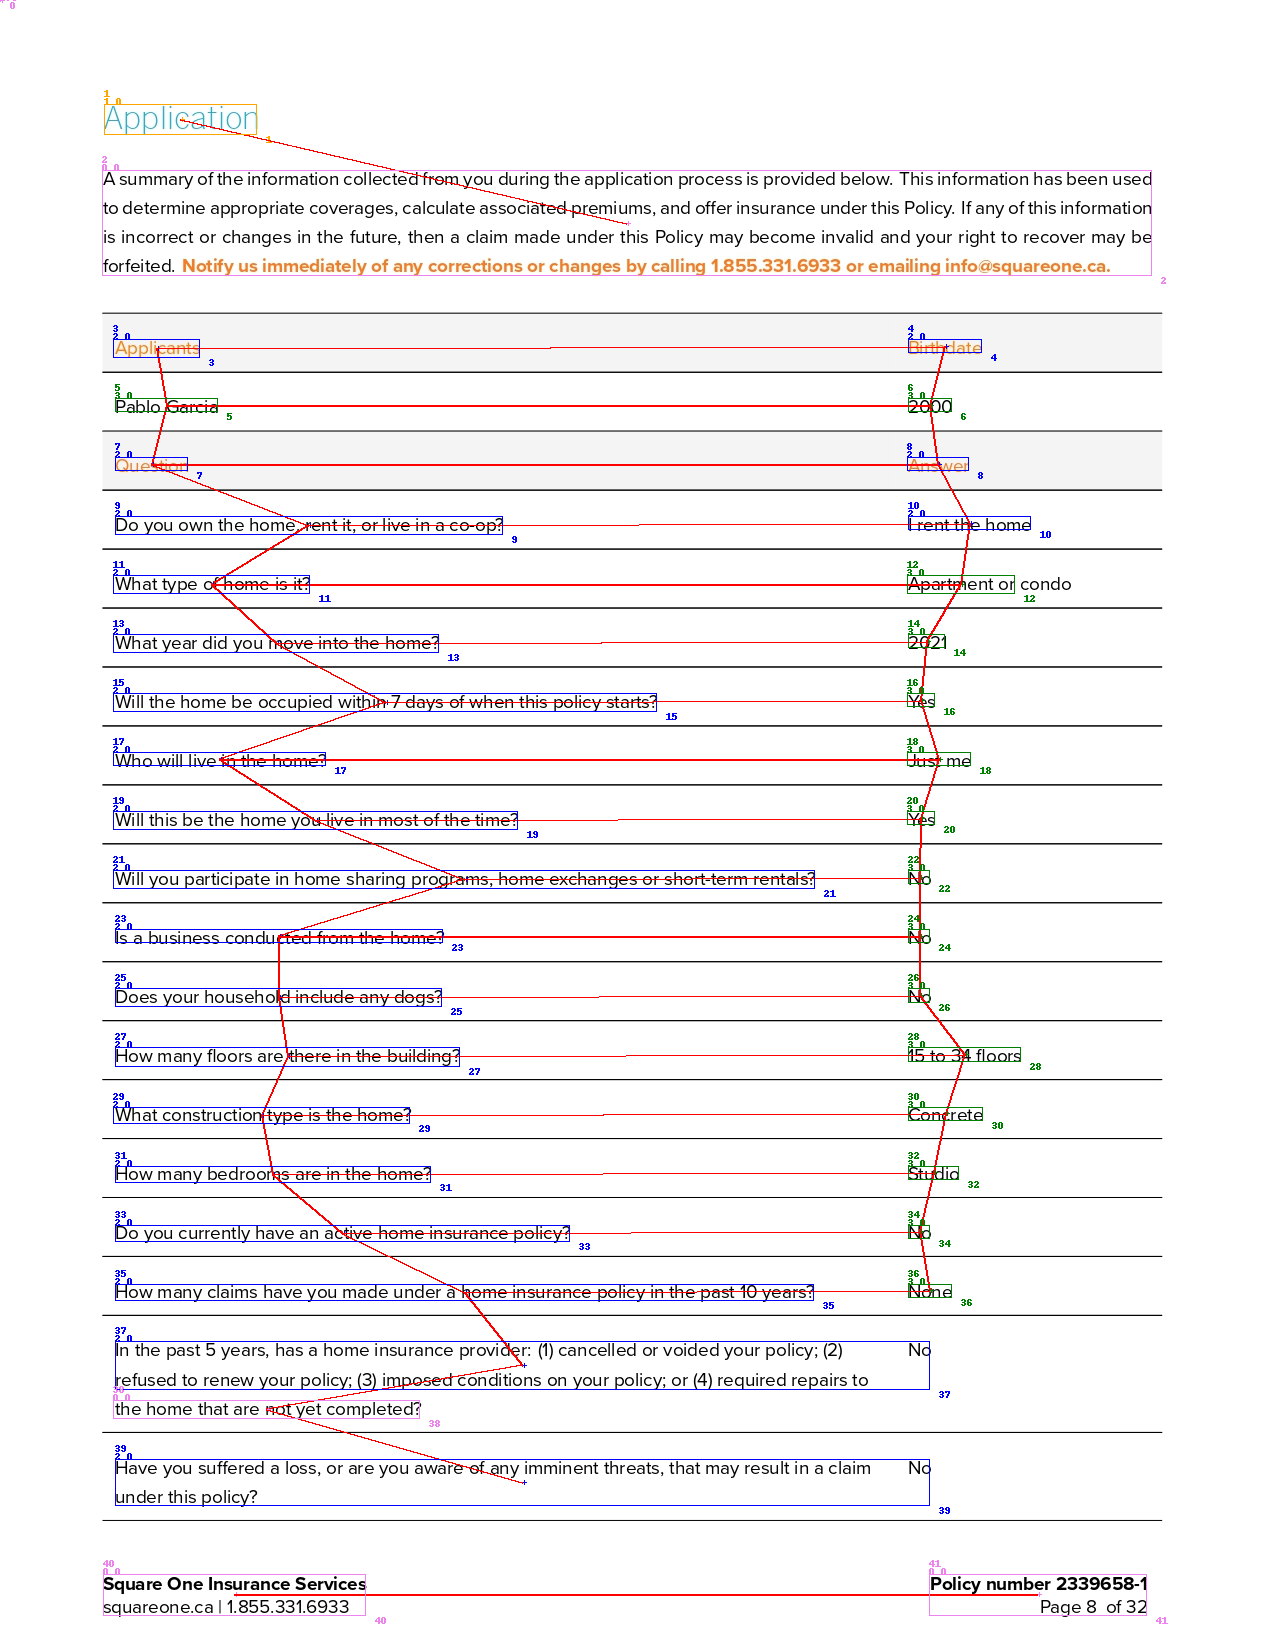

In [ ]:
### LINKEMAOS Q+As

## Calculamos los centros de los párrafos
par_x_center = (par_x0+par_x1)/2
par_y_center = (par_y0+par_y1)/2

## Utilizamos las funciones Next Right y Next Below (difCompare)
par_x_right = nextRight_difCompare(par_x_center, par_y_center, par_box[:,2], par_box[:,0], 1, 80) # 1, 80
par_y_below = nextBelow_difCompare(par_x_center, par_y_center, par_box[:,0], par_box[:,0], 10, 15) # 10, 15

# Reducir par_type a solo valores no nulos
par_type_clean = []
par_type_clean = par_type[par_type != -1]  
print(par_type_clean)


## Mostramos resultados por pantalla
image = Image.open(imagepath)
image = image.convert("RGB")
image = image.crop(area)

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

for i in range(len(par_type_clean)):
  draw.text((par_box[i][0], par_box[i][1]-8), text=str(par_type_clean[i]), fill=label2color[par_type_clean[i]], font=font)
  draw.text((par_box[i][0], par_box[i][1]-16), text=str(i), fill=label2color[par_type_clean[i]], font=font)
  draw.text((par_box[i][2]+10, par_box[i][3]), text=str(i), fill=label2color[par_type_clean[i]], font=font)
  draw.text((par_x_center[i], par_y_center[i]-5), text='+', fill=label2color[par_type_clean[i]], fonf=font)
      
  draw.line([(par_x_center[i],par_y_center[i]), (par_x_center[par_x_right[i]],par_y_center[par_x_right[i]])], fill= 'red', width=2, joint=None)
  draw.line([(par_x_center[i],par_y_center[i]), (par_x_center[par_y_below[i]],par_y_center[par_y_below[i]])], fill= 'red', width=2, joint=None)

  par_box_temp = [par_box[i][0], par_box[i][1], par_box[i][2], par_box[i][3]]
  draw.rectangle(par_box_temp, outline=label2color[par_type_clean[i]])

image

In [ ]:
## Algoritmo primera iteración Right
link_matrix_right_1 = np.zeros((len(par_x_right), len(par_y_below)))
link_type_right_1 = np.zeros(len(par_x_right))  # 0: Single, 1: Question + Answer
a_of_q_right = np.zeros(len(par_x_right))

for i in range(len(par_type_clean)):
  # Question + Answer  
  if(par_type_clean[i] == 2 and par_type_clean[par_x_right[i]] == 3):
    link_matrix_right_1[i][i] = 1
    link_matrix_right_1[i][par_x_right[i]] = 1

    link_type_right_1[i] = 1
    link_type_right_1[par_x_right[i]] = 1
    #print(i)
    #print(par_x_right[i])

    a_of_q_right[par_x_right[i]] = 1


## Algortirmo primera iteración Below
link_matrix_below_1 = np.zeros((len(par_x_right), len(par_y_below)))
link_type_below_1 = np.zeros(len(par_x_right))  # 0: Single, 1: Question + Answer
a_of_q_below = np.zeros(len(par_y_below))

for i in range(len(par_type_clean)):

  # Question + Answer  
  if(par_type_clean[i] == 2 and par_type_clean[par_y_below[i]] == 3):
    link_matrix_below_1[i][i] = 1
    link_matrix_below_1[i][par_y_below[i]] = 1

    link_type_below_1[i] = 1
    link_type_below_1[par_y_below[i]] = 1

    a_of_q_below[par_y_below[i]] = 1


## Algoritmo segunda iteración Right
link_2_right = np.zeros(len(a_of_q_right))

for i in range(len(par_x_right)):

  if(a_of_q_right[i] == 1):
    if(link_type_right_1[par_x_right[i]] == 0 and link_type_below_1[par_x_right[i]] == 0 and par_type_clean[par_x_right[i]] == 3):
      link_2_right[i] = 1
    
    elif(link_type_right_1[par_y_below[i]] == 0 and link_type_below_1[par_y_below[i]] == 0 and par_type_clean[par_y_below[i]] == 3):
      link_2_right[i] = 2


## Algoritmo segunda iteración Below
link_2_below = np.zeros(len(a_of_q_below))

for i in range(len(par_y_below)):

  if(a_of_q_below[i] == 1):
    if(link_type_right_1[par_x_right[i]] == 0 and link_type_below_1[par_x_right[i]] == 0 and par_type_clean[par_x_right[i]] == 3):
      link_2_below[i] = 1
    
    elif(link_type_right_1[par_y_below[i]] == 0 and link_type_below_1[par_y_below[i]] == 0 and par_type_clean[par_y_below[i]] == 3):
      link_2_below[i] = 2

## Creación de lista completa de relaciones
link_list = np.zeros(3)

for i in range(link_matrix_right_1.shape[0]):

  temp = np.zeros(3)
  count = 0

  for j in range(link_matrix_right_1.shape[1]):

    if(link_matrix_right_1[i,j] != 0):
      temp[count] = j

      if(count > 0):
        if(link_2_right[j] == 1):
          temp[2] = par_x_right[j]
        elif(link_2_right[j] == 2):
          temp[2] = par_y_below[j]

      count += 1

  link_list = np.vstack([link_list, temp])


link_list_right = link_list[~np.all(link_list == 0, axis=1)]


link_list = np.zeros(3)

for i in range(link_matrix_below_1.shape[0]):

  temp = np.zeros(3)
  count = 0

  for j in range(link_matrix_below_1.shape[1]):

    if(link_matrix_below_1[i,j] != 0):
      temp[count] = j

      if(count > 0):
        if(link_2_below[j] == 1):
          temp[2] = par_x_right[j]
        elif(link_2_below[j] == 2):
          temp[2] = par_y_below[j]

      count += 1

  link_list = np.vstack([link_list, temp])


link_list_below = link_list[~np.all(link_list == 0, axis=1)]

link_list = np.concatenate((link_list_right, link_list_below))
sorted_link_list = link_list[np.argsort(link_list[:, 0])]
print(sorted_link_list)

[[ 3.  5.  0.]
 [ 4.  6.  0.]
 [10. 12.  0.]
 [11. 12.  0.]
 [13. 14.  0.]
 [15. 16.  0.]
 [17. 18.  0.]
 [19. 20.  0.]
 [21. 22.  0.]
 [23. 24.  0.]
 [25. 26.  0.]
 [27. 28.  0.]
 [29. 30.  0.]
 [31. 32.  0.]
 [33. 34.  0.]
 [35. 36.  0.]]


## OCR Text Extraction

In [ ]:
import pytesseract

par_text = []

image = Image.open(imagepath)
image = image.convert("L")
image = image.crop(area)

black = (0)
white = (255)
threshold = (200)

for i in range(len(par_type_clean)):
  margin = 5
  area = par_box[i][0]-margin, par_box[i][1]-margin, par_box[i][2]+margin, par_box[i][3]+margin
  cut_image = image.crop(area)

  pixels = cut_image.getdata()

  newPixels = []

  for pixel in pixels:
     if pixel < threshold:
         newPixels.append(black)
     else:
          newPixels.append(white)

  newImg = Image.new("RGB",cut_image.size)
  newImg.putdata(newPixels)

  text_temp = pytesseract.image_to_string(newImg)
  par_text.append(text_temp.strip())


## Guardamos todos los pares de Q+As en un Excel
import csv

with open('output_alltext.csv', 'w') as file:

  writer = csv.writer(file)

  for i in range(len(sorted_link_list)):
    temp_row = [par_text[int(sorted_link_list[i][0])], par_text[int(sorted_link_list[i][1])], par_text[int(sorted_link_list[i][2])]]
    writer.writerow(temp_row)


In [ ]:
# 1 Resumir solo Others
# 2 Guardar todo Texto
# 3 Guardar solo Q+As y Texto Resumido
# 4 Sentence Simmilarity
# 5 Guardar valores objetivo

In [ ]:
## Resumir Others y guardar todo en un nuevo par_text_summ
from transformers import pipeline
from math import sqrt

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def textSumm(text2summ):
  
  max_length = int(sqrt(7*len(text2summ)))
  min_length = int(sqrt(4*len(text2summ)))
  
  textSummarized = summarizer(text2summ, max_length=max_length, min_length=min_length, do_sample=False)
  
  return textSummarized

par_text_summ = []

for i in range(len(par_text)):

  if(par_type_clean[i] == 0):
    ## Introducir la funcion textSumm
    #par_text_summ.append(textSumm(par_text[i]))
    par_text_summ.append(par_text[i])
  else:
    par_text_summ.append(par_text[i])

In [ ]:
## Guardar todo el texto
with open('allText.csv', 'w') as file:

  writer = csv.writer(file)

  for i in range(len(par_text_summ)):
    temp_row = par_text_summ[i]
    writer.writerow(temp_row)

In [ ]:
## Guardar Q+As y Others Resumidos

linked_qas = [['No se han encontrado coincidencias', 'N/A']]
linked_others = [['No se han encontrado coincidencias', 'N/A']]

with open('QandAs_Others.csv', 'w') as file:

  writer = csv.writer(file)

  writer.writerow(['Preguntas', 'Respuesta 1', 'Respuesta 2'])
  writer.writerow(['\n'])

  for i in range(len(sorted_link_list)):
    temp_row = [par_text_summ[int(sorted_link_list[i][0])], par_text_summ[int(sorted_link_list[i][1])], par_text_summ[int(sorted_link_list[i][2])]]
    linked_qas.append(temp_row)
    writer.writerow(temp_row)

  writer.writerow(['\n'])
  writer.writerow(['\n'])
  writer.writerow(['Otros'])
  writer.writerow(['\n'])

  for i in range(1, len(par_text_summ)):
    if(par_type_clean[i] == 0):
      temp_row = par_text_summ[i]
      linked_others.append(temp_row)
      writer.writerow([temp_row])


In [ ]:
### Sentence Similarity

## Diccionarios
diccionario_generico = {'PolicyNumber' : ['Policy Number'],
               'NameInsured' : ['Name insured', 'Applicants', 'Name'], 
               'EffectiveDate' : ['Effective', 'Effective date', 'Policy effective date'],
               'Coverage' : ['Coverage'],
               'Premium' : ['Premium'],
               'Limit' : ['Limit'],
               'Deductible' : ['Deductible']
               }

diccionario_house = {'Bicycles, Sporting Equipment and Watercraft' : ['Bicycles', 'Sporting Equipment and Watercraft'],
                     'Business Property' : ['Business Property'],
                     'Fine Arts and Collectibles' : ['Fine Arts and Collectibles'],
                     'Jewellery and Watches' : ['Jewellery and Watches'],
                     'Personal Property' :['Personal Property']
                     }

## Modelo
import numpy as np
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')


def SentenceSimilarity(docText, dictionary):

  docText_embeddings = model.encode(docText)
  dictionary_embeddings = model.encode(dictionary)

  similarity = np.empty([len(docText), len(dictionary)])

  for i in range(len(docText_embeddings)):
    for j in range(len(dictionary_embeddings)):
      similarity[i][j] = util.pytorch_cos_sim(docText_embeddings[i], dictionary_embeddings[j])
  
  single_similarity = np.max(similarity, axis=1)

  max_coincidence = np.max(single_similarity, axis=0)
  max_index = np.argmax(single_similarity, axis=0)
  

  if(max_coincidence < 0.7):
    max_index = 0

  return max_index


with open('KeyValuePairs.csv', 'w') as file:

  writer = csv.writer(file)
  
  writer.writerow(["Diccionario Generico"])
  writer.writerow(['\n'])

  for key in diccionario_generico:
    max_index = SentenceSimilarity([x[0] for x in linked_qas], diccionario_generico[key])
    
    temp_row = [key, linked_qas[max_index][1]]
    writer.writerow(temp_row)

  writer.writerow(['\n'])
  writer.writerow(['\n'])
  writer.writerow(['Diccionario House'])
  writer.writerow(['\n'])
  
  for key in diccionario_house:
    max_index = SentenceSimilarity([x[0] for x in linked_qas], diccionario_house[key])
    
    temp_row = [key, linked_qas[max_index][1]]
    writer.writerow(temp_row)
